In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here we calculate the theoretical power output of a induction generator consisting of cylindrical magnet moving along the z axis in a periodic fashion.

The approach is the following:
* Discretize the coil into M sections.
* For each section apply Faradays law to get the electric field along 


In [43]:
def plot(t, V, R, f = None):
    # Induced current (Ohm's Law)
    I = V / R

    # Power generated
    P = V * I



    print("Calculated Resistance: ", R)
    print("Constant Power Generated: ", P.mean())

    # Plotting the results
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, V)


    
    plt.title('Induced Voltage')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')

    plt.subplot(3, 1, 2)
    plt.title('Induced Current')
    plt.plot(t, I)
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A)')

    plt.subplot(3, 1, 3)
    plt.plot(t, P)
    plt.title('Generated Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')

    if (f is not None):
        # Add a secondary plot that shows the aplitude of the motion.
        # A new axis will be needed because the magnitude of the movement is different to that of voltage.
        z = np.vectorize(f)(t) # Calculate the position of the magnet at each time step.
        ax2 = plt.gca().twinx()
        ax2.plot(t, z, 'r--')
        
    plt.tight_layout()
    plt.show()

Resistance of the coil: 6.72 ohms


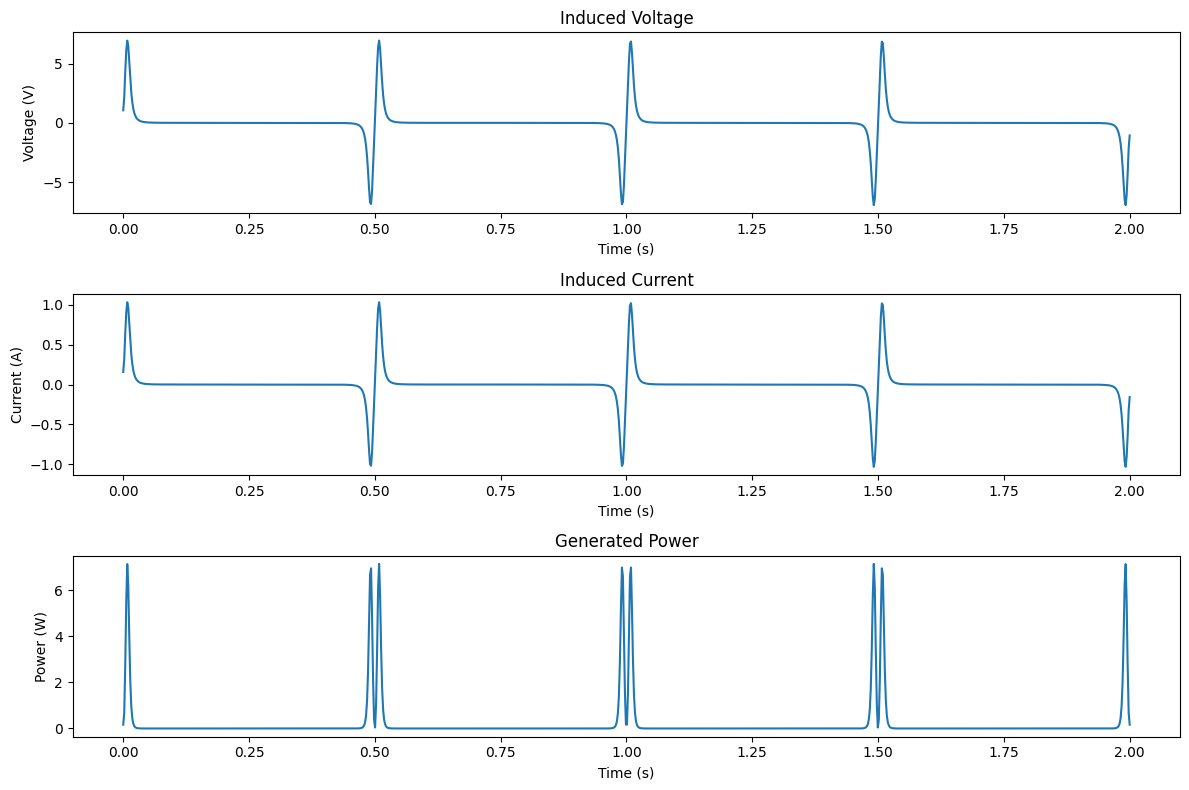

In [3]:
# Parameters
z0 = 1  # Amplitude of the motion (m)
omega = 2 * np.pi * 1  # Angular frequency (rad/s)
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)
m = 1  # Magnetic moment (A*m^2)
coil_length = 0.1  # Length of the coil (m)
num_segments = 100  # Number of segments to divide the coil

# Calculate the resistance of the coil
N = 1000  # Number of turns in the coil
coil_radius = 0.05  # Radius of the coil in meters (5 cm)
d_wire = 0.001  # Diameter of the wire in meters (1 mm)
L_wire = 2 * np.pi * coil_radius * N
A_wire = np.pi * (d_wire / 2)**2
rho_copper = 1.68e-8  # Resistivity of copper in ohm meters
R = rho_copper * L_wire / A_wire

# Time array
t = np.linspace(0, 2, 1000)  # Time from 0 to 2 seconds

# Magnet motion
z = z0 * np.sin(omega * t)
dz_dt = z0 * omega * np.cos(omega * t)

# Computational parameters
discretization = 1000  # Discretization of the coil

# Discretize the coil
segment_length = coil_length / discretization
z_segments = np.linspace(-coil_length / 2, coil_length / 2, discretization)

# Magnetic field B at the coil
def magnetic_field(z, z_segment, r, m, mu0):
    return (mu0 / (4 * np.pi)) * (2 * m) / (((z - z_segment) ** 2 + r ** 2) ** (3 / 2))

def magnetic_flux_at_z(z, z_segment, r, m, mu0):
    B = magnetic_field(z, z_segment, r, m, mu0)
    A = np.pi * r ** 2
    return B * A

# Calculates the electric field at the coil at z. Z can be a vector.
def electric_field_at_z(z, z_segment, r, m, mu0, N, omega):
    # Calculate the magnetic flux through a disc at z.
    flux = magnetic_flux_at_z(z, z_segment, r, m, mu0)


# Calculate the magnetic flux through each segment and sum them up
def total_flux(z, z_segments, coil_radius, num_segments):
    A = np.pi * coil_radius ** 2  # Area of the coil
    flux = np.zeros_like(z)
    for z_seg in z_segments:
        B = magnetic_field(z, z_seg, coil_radius, m, mu0)
        flux += B * A / num_segments
    return flux

# Compute total magnetic flux
Phi = N * total_flux(z, z_segments, coil_radius, num_segments)

# Induced voltage (Faraday's Law)
V = -np.gradient(Phi, t)

# Induced current (Ohm's Law)
I = V / R

# Power generated
P = V * I


print("Resistance of the coil: {:.2f} ohms".format(R))

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, V)
plt.title('Induced Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.subplot(3, 1, 2)
plt.plot(t, I)
plt.title('Induced Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')

plt.subplot(3, 1, 3)
plt.plot(t, P)
plt.title('Generated Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')

plt.tight_layout()
plt.show()

Shape of the flux:  ()
Total magnetic flux through the disc: 0.00962376751744351 T*m^2


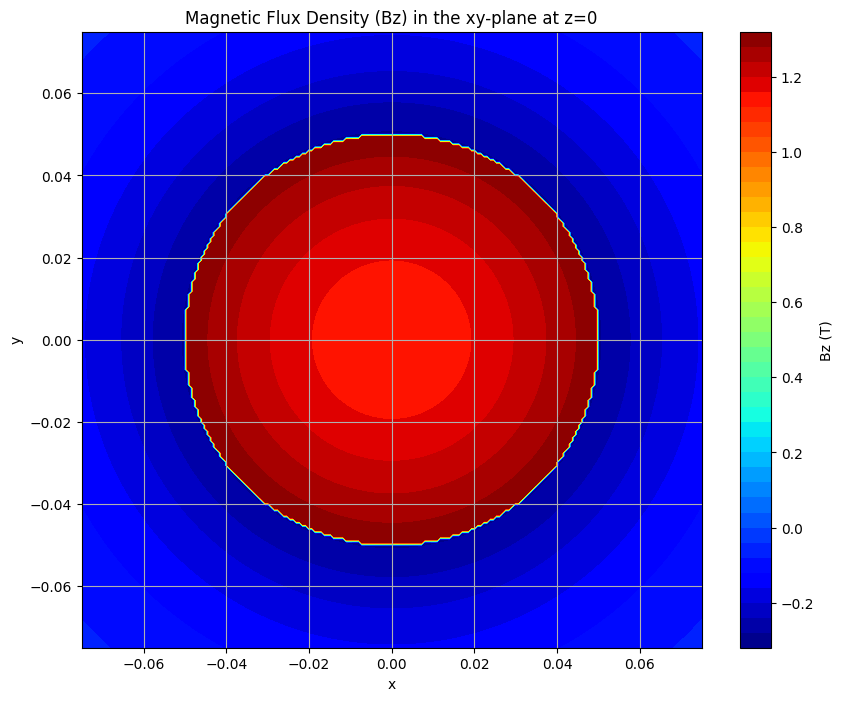

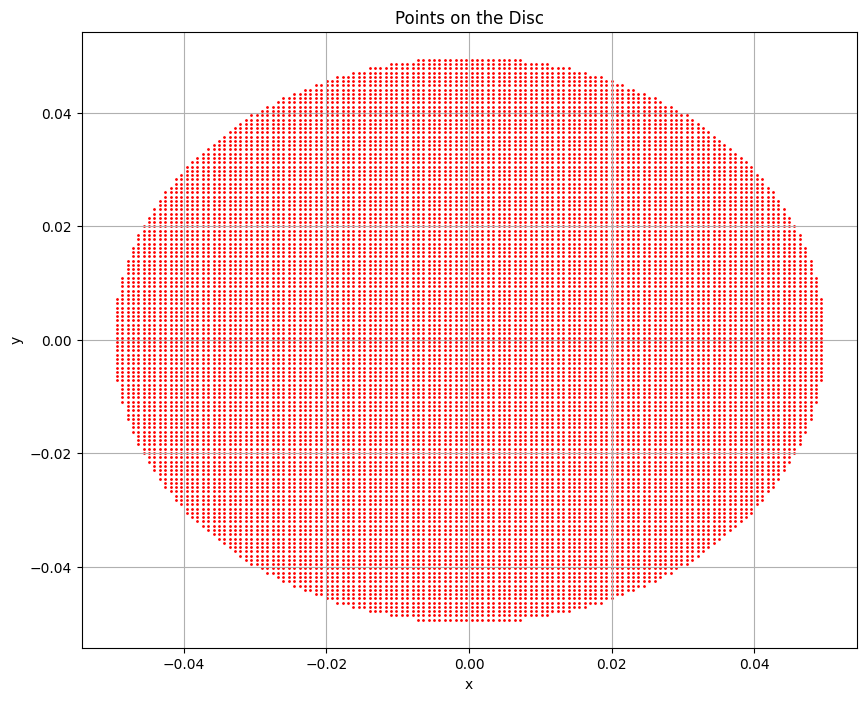

Number of points on the disc:  13796 (13796, 3)
Total magnetic flux through the disc (points):  0.009622441487390228
Area of the disc:  0.007853981633974483


In [4]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt

magnetization_of_neodymium_magnet = 1.27e6
# Magnet parameters

magnetization = magnetization_of_neodymium_magnet  # Magnetization direction and magnitude
cylinder_radius = 0.05  # Radius of the cylinder in arbitrary units
cylinder_length = 0.1  # Length of the cylinder in arbitrary units
discretization = 3

# Discretization parameters
z_segments = np.linspace(-cylinder_length / 2, cylinder_length / 2, 3)  # Segments along the z-axis


def create_cylinder_magnet(radius, length, magnetization=magnetization):
    """
    Create a cylindrical magnet using magpylib.
    
    Parameters:
    - magnetization: Magnetization vector
    - radius: Radius of the cylinder
    - length: Length of the cylinder
    
    Returns:
    - Cylindrical magnet object
    """
    magnet = magpy.magnet.Cylinder(magnetization=(0, 0, magnetization), dimension=(radius * 2, length))
    return magnet

# Create a cylindrical magnet
magnet = create_cylinder_magnet(cylinder_radius, cylinder_length, magnetization)

# Vectorized function to evaluate the magnetic flux density at given points (r, z)
def calculate_flux(z, magnet, z_segments, disc_radius, r_discretization):
    """
    Calculate the magnetic flux through a set of discs at positions of z_segments.

    Args:
        z (float): The offset position of the magnet from the origin.
        magnet: The magnet object used to calculate the magnetic flux 
        z_segments (array-like): The array of z-coordinates for each disc that the flux is calculated through.
        disc_radius (float): The radius of the discs.
        r_discretization (int): An integer representing the granularity of discretization in the radial direction.
    
    Returns:
        array-like: An array containing the magnetic flux through each z and disc. Shape is (len(z), len(z_segments)).
    """

    # For efficiency we buld a tensor that contains the z-coordinates of the discs for each z position.
    #z_segments_aug = np.expand_dims(z_segments, axis=0) + z  # Add the z offset to each z-segment

    z_positions = ((z_segments[..., np.newaxis] + z).T).flatten() 
    

    r_segments = np.linspace(0, disc_radius, r_discretization)  # Radial segments
    # Find the points between each radial segment.
    middle_r = (r_segments[1:] + r_segments[:-1]) / 2
    R, Z = np.meshgrid(middle_r, z_positions)  # Create a grid of r and z points
    X = R.flatten()
    Y = np.zeros_like(X)
    Z = Z.flatten()
    
    # Calculate the magnetic flux density at all points
    B = magnet.getB(np.column_stack((X, Y, Z)))

    Bz = B[:, 2]  # Extract the z-component of the magnetic flux density


    # The Bz entries start from the first z, z-segment and middle radius, visit each middle radius value in the z-segment, and then move to the next z-segment, visit each z-segment and the move to the next z.
    # We need to calculate the flux for each segment. 
    # Calculate the flux through each segment by multiplying the area of the annular sector by the magnetic flux density at the middle radius of the segment.    

    annular_areas = np.pi * (r_segments[1:] ** 2 - r_segments[:-1] ** 2)  # Area of each slice of the disc
    annular_areas = np.tile(annular_areas, len(z_positions)) # Repeat the annular areas for each z-segment. (These are the same for each z-segment.)
    flux_elements = annular_areas * Bz # Multiply the area by the magnetic flux density to get the flux through each annular sector.
    flux_through_segment = flux_elements.reshape((len(z), len(z_segments), len(middle_r))).sum(axis=2) # Sum the flux through each annular sector to get the total flux through each z-segment.

    
    return flux_through_segment

# Calculate the magnetic flux through the disc
flux = calculate_flux(np.array([0, 0.01]), magnet, np.array([0, 0.005]), cylinder_radius, 200)[0][0]
print("Shape of the flux: ", flux.shape)
print(f"Total magnetic flux through the disc: {flux} T*m^2")


# Optional: visualize the magnetic field along a plane
x = np.linspace(-1.5 * cylinder_radius, 1.5 * cylinder_radius, 200)
y = np.linspace(-1.5 * cylinder_radius, 1.5 * cylinder_radius, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Vectorized magnetic field calculation
points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
B = magnet.getB(points)
Bz = B[:, 2].reshape(X.shape)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Bz, levels=50, cmap='jet')
plt.colorbar(label='Bz (T)')
plt.title(f"Magnetic Flux Density (Bz) in the xy-plane at z={0}")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Sanity check
# Calculate the magnetic flux through the disc by taking the points on the disc.

# Filter the points on the disc
points_on_disc = points[np.linalg.norm(points[:, :2], axis=1) <= cylinder_radius]

# Plot the points on the disc
plt.figure(figsize=(10, 8))
plt.scatter(points_on_disc[:, 0], points_on_disc[:, 1], c='r', s=1)
plt.title("Points on the Disc")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# Assume that the points on the disc represent area elements.
# Calculate the area of each element.
area_element = np.pi * cylinder_radius ** 2 / len(points_on_disc)
print("Number of points on the disc: ", len(points_on_disc),  points_on_disc.shape)

# Get the field density at the points on the disc
b = magnet.getB(points_on_disc)
flux_points = np.sum(np.dot(b, area_element))
print("Total magnetic flux through the disc (points): ", flux_points)

print("Area of the disc: ", np.pi * cylinder_radius ** 2)


In [5]:
# Magnetic field B at the coil
def magnetic_field(z, z_segment, r, m, mu0):
    return (mu0 / (4 * np.pi)) * (2 * m) / (((z - z_segment) ** 2 + r ** 2) ** (3 / 2))


# Calculate the voltage across the coil by summing up the voltages across the coil segments.
# t: Time array
# z: Position of the magnet
# z_segments: Position array of the coil segments
# r: Radius of the coil
# m: Magnetic moment
# mu0: Permeability of free space
# N: Number of turns in the coil
# coil_length: Length of the coil
# segment_length: Length of the coil segment
def calculate_voltage_old(t, z, z_segments, r, m, mu0, N, coil_length, segment_length):



    def magnetic_flux_at_z(z, z_segment, r, m, mu0):
        B = magnetic_field(z, z_segment, r, m, mu0) # Simplistic assumption of constant magnetic field at the disc.
        A = np.pi * r ** 2
        return B * A
    
    V = np.zeros_like(z)
    for z_seg in z_segments:
        # For each segment we use Faradays law to calculate the voltage.
        # Faradays law states that the integral over a closed loop of the electric field is equal to the negative rate of change of the magnetic flux through the loop.
        # Let the loop be at z_seg and have radius r.
        B = magnetic_flux_at_z(z, z_seg, r, m, mu0)
        dB_dt = np.gradient(B, t)

        # To get the electric field we need to divide by the circumference of the loop. This can be done due to symmetry.
        E = -dB_dt / (2 * np.pi * r)

        # Assume that the discretization is small enough that the electric field induced by the changing magnetic flux is constant over the segment.
        # Then we can calculate the voltage by integrating the electric field over the coil wire. Keeping in mind that the wire is not exactly parallel to the electric field.
        parallel_component_of_the_wire = 2 * np.pi * r * N / coil_length * segment_length
        V += E * parallel_component_of_the_wire
    
    return V


Calculated Resistance:  101.81808000000002
Constatant Power Generated:  0.007124842567748125


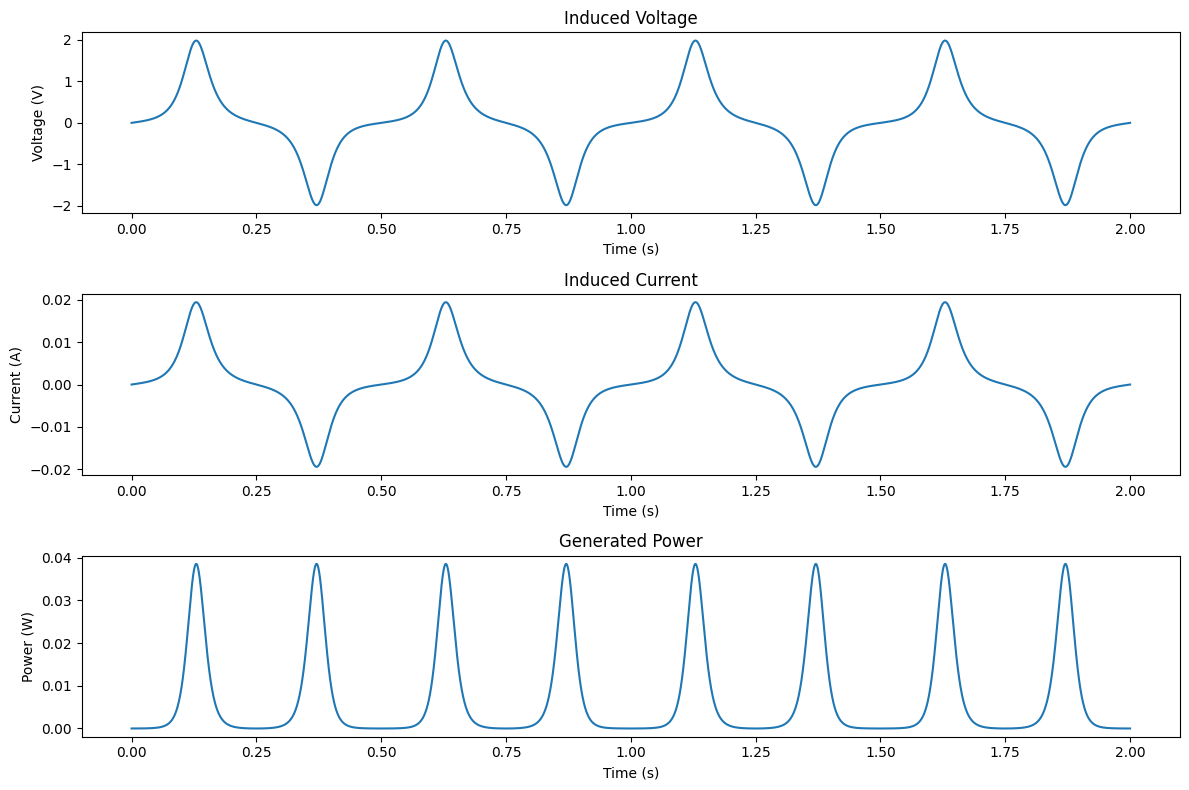

In [6]:
# Parameters
z0 = 0.03  # Amplitude of the motion (m)
frequency = 1  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)
m = 1  # Magnetic moment (A*m^2)
coil_length = 0.0445  # Length of the coil (m)

# Calculate the resistance of the coil
N = 5772  # Number of turns in the coil
coil_radius = 0.0105/2  # Radius of the coil in meters
d_wire = 0.0002   # Diameter of the wire in meters (0.2 mm)
wire_length = 2 * np.pi * coil_radius * N
wire_cross_section = np.pi * (d_wire / 2)**2
rho_copper = 1.68e-8  # Resistivity of copper in ohm meters
R = rho_copper * wire_length / wire_cross_section

# Time array
t = np.linspace(0, 2, 100000)  # Time from 0 to 2 seconds

# Magnet motion
z = z0 * np.sin(omega * t)
dz_dt = z0 * omega * np.cos(omega * t)

# Computational parameters
discretization = 1000  # Discretization of the coil

# Discretize the coil
segment_length = coil_length / discretization
z_segments = np.linspace(-coil_length / 2, coil_length / 2, discretization)




# Calculate the voltage across the coil by summing up the voltages across the coil segments.

V = calculate_voltage_old(t, z, z_segments, coil_radius, m, mu0, N, coil_length, segment_length)
plot(t, V, R)

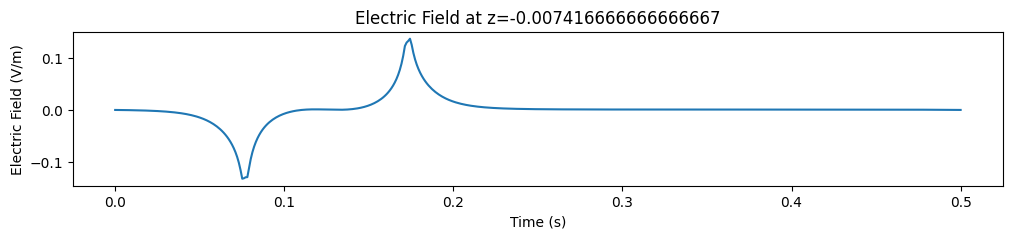

Calculated Resistance:  50.90904000000001
Constatant Power Generated:  0.009793082245997353


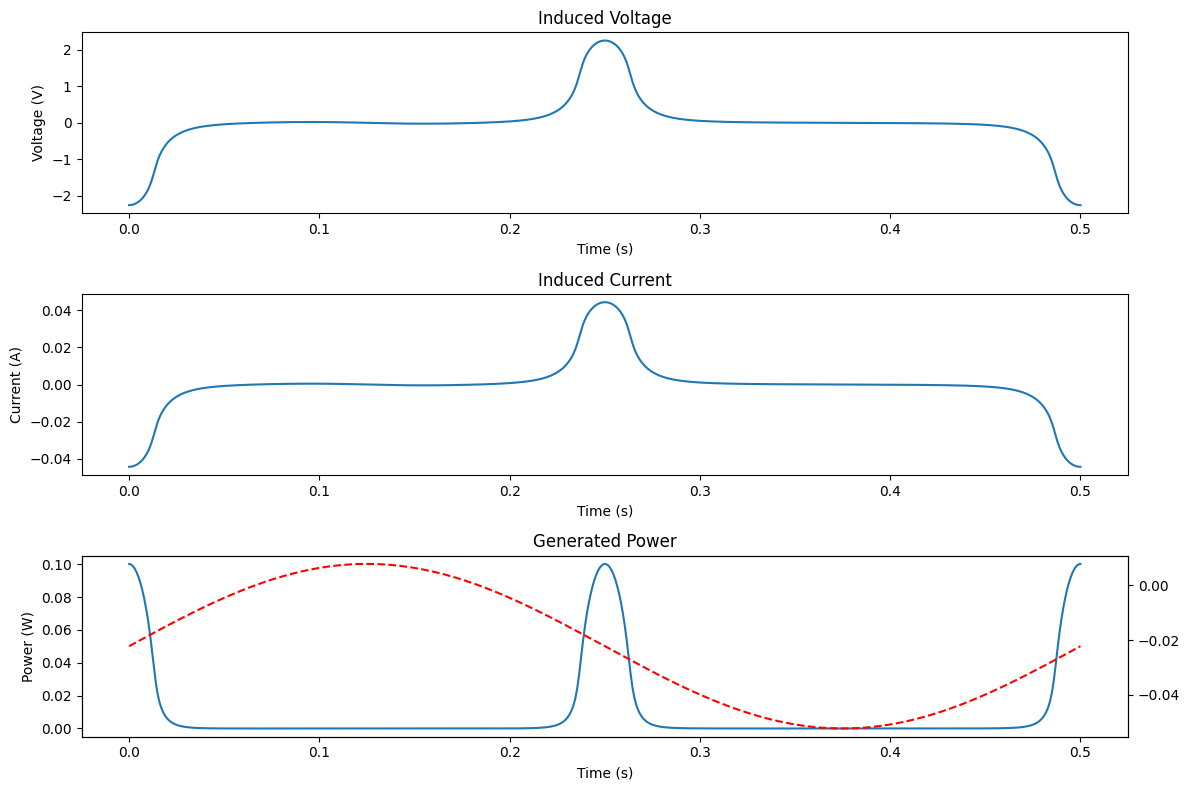

In [34]:
# Assume that the coil is the size of an aaa battery. The magnet is suspended isndie the coil and is oscillating up and down.

def calculate_resistance_of_coil(N=5772, coil_radius=0.0105/2, d_wire=0.0002, rho=1.68e-8):
    """
    Calculate the resistance of the coil.
    """
    # Calculate the resistance of the coil
    wire_length = 2 * np.pi * coil_radius * N
    wire_cross_section = np.pi * (d_wire / 2)**2
    R = rho_copper * wire_length / wire_cross_section
    return R

multiplier = 1
# Motion parameters
offset = -0.0445/2  # Offset of the motion (m)
amplitude = 0.03  # Amplitude of the motion (m)
frequency = 2  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)2

# Physical constants
magnetization = 1.27e6 # Magnetization of a neodymium magnet in A/m

coil_length = 0.0445 * multiplier  # Length of the coil (m)
coil_radius = 0.0105 / 2  # Radius of the coil (m)
N = 5772 / 2 * multiplier # Number of turns in the coil

R = calculate_resistance_of_coil(N, coil_radius, 0.0002, 1.68e-8)

# The magnet radius must be slightly smaller than the coil radius.
magnet_radius = 0.01 / 2  # Radius of the magnet in meters
magnet_length = 0.01  # Length of the magnet in meters



magnet = create_cylinder_magnet(magnet_radius, magnet_length, magnetization)

def calculate_voltage(t, z_func, r, N, coil_length, magnet, r_discretization=3, z_discretization=4):
    """
    Calculate the voltage across the coil by summing up the voltages across the coil segments.
    
    Parameters:
    - t: Time array
    - z_func: Function that takes t and returns z
    - z_segments: Position array of the coil segments
    - r: Radius of the coil
    - m: Magnetic moment
    - mu0: Permeability of free space
    - N: Number of turns in the coil
    - coil_length: Length of the coil
    - segment_length: Length of the coil segment
    - magnet: The magnet object used to calculate the magnetic flux density
    
    Returns:
    - Voltage across the coil (array)
    """

    z = np.vectorize(z_func)(t)

    z_segments = np.linspace(-coil_length / 2, coil_length / 2, z_discretization)  # Segments along the z-axis
    segment_length = coil_length / z_discretization  # Length of each segment
    flux_through_segments = calculate_flux(z, magnet, z_segments, r, r_discretization)
    
    # Calculate the rate of change of magnetic flux with respect to time
    dB_dt = np.gradient(flux_through_segments, t, axis=0)
    
    # Calculate the induced electric field
    E = -dB_dt / (2 * np.pi * r)

    # Plot the electric field at a specific position to debug.
    evaluate_at = z_discretization // 3
    plt.figure(figsize=(12, 2))
    plt.plot(t, E[:, evaluate_at])
    plt.title(f"Electric Field at z={z_segments[evaluate_at]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Electric Field (V/m)")
    plt.show()

    # Calculate the parallel component of the wire
    parallel_component_of_the_wire = 2 * np.pi * r * N / coil_length * segment_length
    
    # Calculate the total voltage across the coil
    V = np.sum(E * parallel_component_of_the_wire, axis=1)
    
    return V


# Time array
t = np.linspace(0, 0.5, 500)  # Time from 0 to 1 seconds

equation_of_motion = lambda t: amplitude * np.sin(omega * t) + offset
# Calculate the voltage across the coil by summing up the voltages across the coil segments
V = calculate_voltage(t, equation_of_motion, coil_radius, N, coil_length, magnet, r_discretization=20, z_discretization=1000*multiplier)

plot(t, V, R, equation_of_motion)


Inner radius:  0.002849999999999997


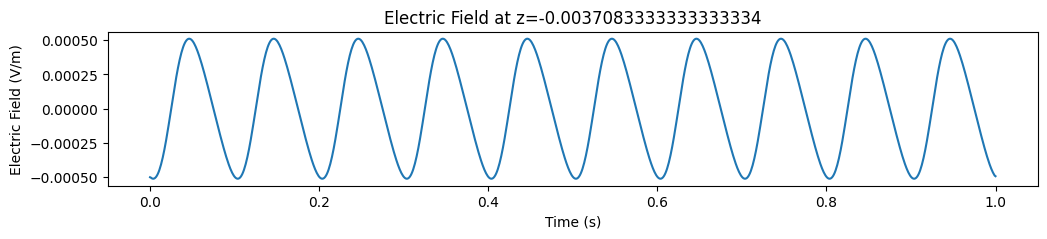

Calculated Resistance:  55.12500000000001
Constant Power Generated:  0.0032232941074005705


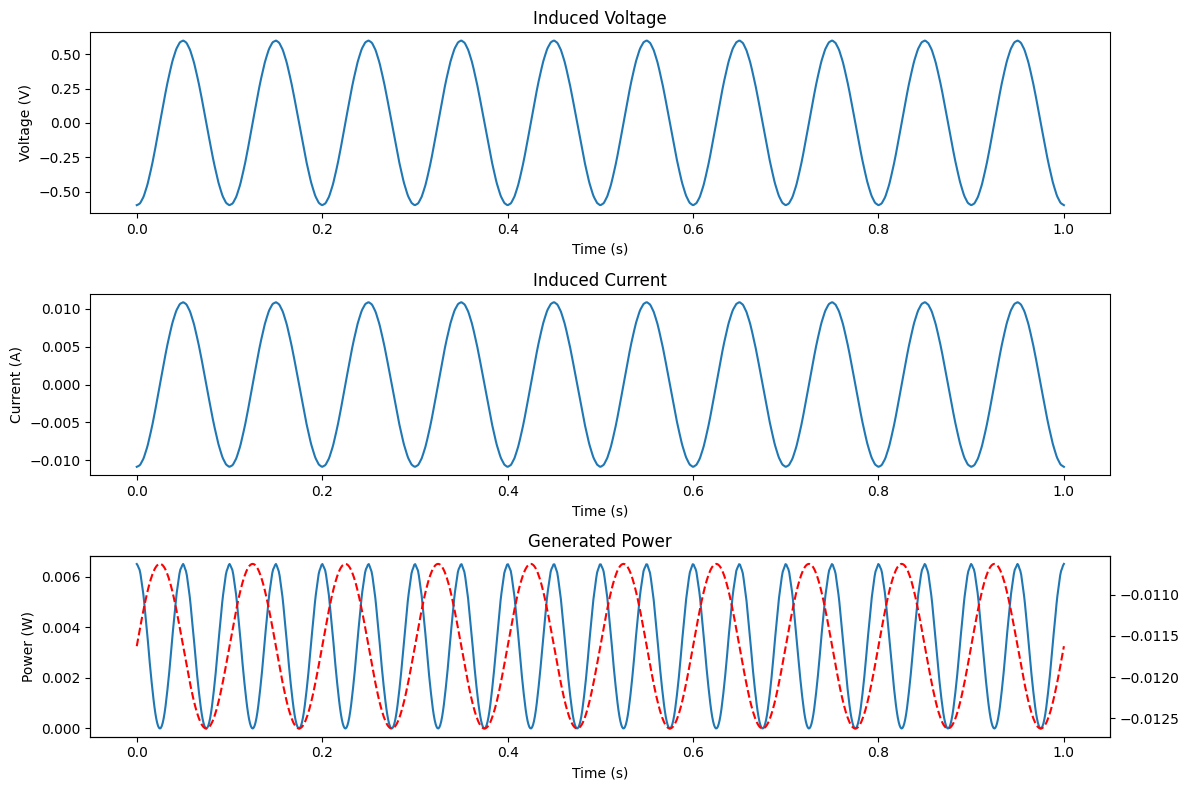

In [54]:
# This is the simulation of a design that consists of two coils and a magnet swinging inside the coils. At rest the magnet is positioned between the coils.
# The generator should have the dimensions of an AAA battery.

def calculate_inner_radius(outer_radius, coil_length, number_of_turns, wire_diameter):
    # Calculate the number of turns per layer
    turns_per_layer = coil_length / wire_diameter
    
    # Initialize variables
    remaining_turns = number_of_turns
    current_radius = outer_radius
    
    # Loop through each layer and calculate the inner radius
    while remaining_turns > 0:
        # Check if there is enough radius left for another layer
        if current_radius <= 0:
            raise ValueError("Invalid configuration: The number of turns and wire diameter do not fit into the outer radius.")
        
        # Calculate the number of turns in the current layer
        turns_in_layer = min(remaining_turns, turns_per_layer)
        
        # Subtract the current layer's thickness from the radius
        current_radius -= wire_diameter
        
        # Update remaining turns
        remaining_turns -= turns_in_layer
    
    # The inner radius is the final radius after all layers are wound
    inner_radius = current_radius
    
    # Check if the final inner radius is valid
    if inner_radius <= 0:
        raise ValueError("Invalid configuration: The number of turns and wire diameter do not fit into the outer radius.")
    
    return inner_radius

# Parameters

# Physical constants
magnetization = 1.27e6 # Magnetization of a neodymium magnet in A/m

outer_radius = 0.0105 / 2  # Radius of AAA battery (m)
outer_length = 0.0445  # Length of AAA battery (m) (Could in principle be longer as the battery compartment is open on one side.)
number_of_turns = 2000  # Number of turns in the coil
coil_length = outer_length / 2  # Length of the coil (m)
coil_radius = 0.0105 / 2  # Radius of the coil (m)
coil_separation = 0.001  # Separation/Gap between the two coils (m)

coil_diameter = 0.00016 # Diameter of the wire in meters (0.16 mm) (34 AWG wire)

R = calculate_resistance_of_coil(number_of_turns, coil_radius, coil_diameter, 1.68e-8)
inner_radius = calculate_inner_radius(outer_radius, coil_length, number_of_turns, coil_diameter)
print("Inner radius: ", inner_radius)
magnet_radius = inner_radius - 0.0001
magnet_length = 0.01  # Length of the magnet in meters
magnet = create_cylinder_magnet(magnet_radius, magnet_length, magnetization)

# Now we calculate the voltage accross, say, the right coil. The total voltage is the sum of the voltages across the two coils. 
# The layout is symmetric so the two final voltage should be twice the voltage of the right coil. We will set the origin of the z-axis to the middle of the right coil.

# Determine the resting position of the magnet assuming that there is a separation between the two coils and the magnet is in the middle.
resting_position = -coil_length / 2 - coil_separation / 2

# The magnet is oscillating up and down with a frequency of 2 Hz and an amplitude of 3 cm.
amplitude = 0.001  # Amplitude of the motion (m)
frequency = 10  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)
equation_of_motion = lambda t: amplitude * np.sin(omega * t) + resting_position

# Time array
t = np.linspace(0, 1, 1000)  # Time from 0 to 1 seconds discretized into 1000 points

# Voltage across the right coil
V_right = calculate_voltage(t, equation_of_motion, coil_radius, number_of_turns, coil_length, magnet, r_discretization=20, z_discretization=100*multiplier)

# Total voltage is twice the voltage of the right coil. The coils must be connected so that the voltages add up.
V = 2 * V_right


plot(t, V * 2, R, equation_of_motion)

/Users/sebastian/Documents/Aalto/Savox Battery Booster/python/venv/lib/python3.12/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cylinder(id=4591828432) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()
/Users/sebastian/Documents/Aalto/Savox Battery Booster/python/venv/lib/python3.12/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cylinder(id=4592273792) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()


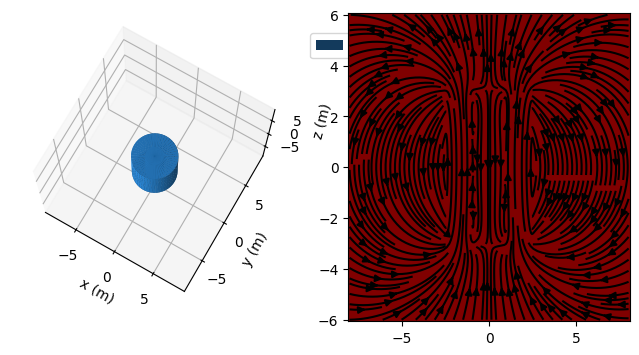

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from magpylib.magnet import Cylinder
import magpylib as magpy

# create collection of two magnets
s1 = Cylinder(magnetization=[0,0,1000], dimension=[5,6])
s2 = Cylinder(magnetization=[0,0,-1000], dimension=[2,6])
c = magpy.Collection(s1,s2)

# create positions
xs = np.linspace(-8,8,100)
zs = np.linspace(-6,6,100)
posis = [[x,0,z] for z in zs for x in xs]

# calculate field and amplitude
B = [c.getB(pos) for pos in posis]
Bs = np.array(B).reshape([100,100,3]) #reshape
Bamp = np.linalg.norm(Bs,axis=2)

# define figure with a 2d and a 3d axis
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

# add displaySystem on ax1

magpy.show(c, canvas=ax1,suppress=True)
ax1.view_init(elev=75)

# amplitude plot on ax2
X,Z = np.meshgrid(xs,zs)
ax2.pcolor(xs,zs,Bamp,cmap='jet',vmin=-200)

# plot field lines on ax2
U,V = Bs[:,:,0], Bs[:,:,2]
ax2.streamplot(X,Z,U,V,color='k',density=2)

#display
plt.show()